

# 두 자산간 가격 차이를 이용한 헷징 매매 전략 지도학습
두 자산간 가격 차이를 나타낸 시계열 데이터에서 이상적인 동작 (buy=0, sell=1) 을 학습하고, 이를 예측하는 지도학습 모델.

<a id='1.1'></a>
## 1.1. 패키지 로드

In [2]:
# 라이브러리 로드
import heapq
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense

<a id='1.2'></a>
## 1.2. 데이터 가져오기

In [118]:
working_dir = 'data/'

# price_funding.csv에서 dataset 저장
# rawdataset = pd.read_csv(working_dir+'price_funding.csv')
rawdataset = pd.read_csv('price_funding.csv')

rawdataset.sort_values(by='timestamp', inplace=True)
rawdataset.reset_index(drop=True, inplace=True)

# kimchi_premium 열의 이름을 price_diff로 변경
rawdataset = rawdataset.rename(columns={'kimchi_premium': 'price_diff'})

#경고 무시
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 2. 탐색적 데이터 분석

<a id='2.1'></a>
## 2.1. 기술 통계

In [119]:
# 데이터셋 구조 확인
rawdataset.shape

# 데이터 확인
pd.set_option('display.width', 100)
rawdataset

,timestamp,KRW-USD,KRW-AERGO,AERGOUSDT,bybit_price_in_krw,price_diff
0,2025-01-13 05:15:00+00:00,1471.469971,188.3,0.1255,184.669481,1.965955
1,2025-01-13 05:16:00+00:00,1471.410034,188.3,0.1254,184.514818,2.051424
2,2025-01-13 05:18:00+00:00,1471.319946,188.3,0.1254,184.503521,2.057673
3,2025-01-13 05:19:00+00:00,1471.319946,189.0,0.1254,184.503521,2.437069
4,2025-01-13 05:20:00+00:00,1471.319946,189.0,0.1256,184.797785,2.273953
...,...,...,...,...,...,...
4806,2025-01-17 21:39:00+00:00,1456.290039,187.8,0.1279,186.259496,0.827074
4807,2025-01-17 21:40:00+00:00,1456.099976,187.7,0.1280,186.380797,0.707800
4808,2025-01-17 21:46:00+00:00,1455.760010,188.5,0.1280,186.337281,1.160647
4809,2025-01-17 21:48:00+00:00,1456.099976,188.5,0.1281,186.526407,1.058077


<a id='3'></a>
# 3. 데이터 준비

<a id='3.1'></a>
## 3.1. 데이터 청소

In [120]:
# null 값 확인
print('Null Values =',rawdataset.isnull().values.any())

Null Values = False


nan값 있으면 dropna로 삭제하든 ffill로 보간하든 해야한다. 안하면 나중에 오류남

In [121]:
# null 값 보간
rawdataset[rawdataset.columns.values] = rawdataset[rawdataset.columns.values].ffill()

In [122]:
rawdataset.tail()

,timestamp,KRW-USD,KRW-AERGO,AERGOUSDT,bybit_price_in_krw,price_diff
4806,2025-01-17 21:39:00+00:00,1456.290039,187.8,0.1279,186.259496,0.827074
4807,2025-01-17 21:40:00+00:00,1456.099976,187.7,0.1280,186.380797,0.707800
4808,2025-01-17 21:46:00+00:00,1455.760010,188.5,0.1280,186.337281,1.160647
4809,2025-01-17 21:48:00+00:00,1456.099976,188.5,0.1281,186.526407,1.058077
4810,2025-01-17 21:49:00+00:00,1456.530029,188.6,0.1281,186.581497,1.081835


<a id='3.3'></a>
## 3.2. 특성 엔지니어링




예측을 만들기 위한 특성들을 정의한다.

아직 이건 연구가 더 필요하다. 모델 성능에 가장 중요한 영향을 주는데, 가장 부족한 부분이다.

In [134]:
# 가격 데이터 정의
df = rawdataset["price_diff"]

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# 시계열 데이터를 일정한 시간 간격으로 분할
t = 100  # 원하는 시간 간격 설정 (예: 5개 데이터 포인트씩 분할)
num_segments = len(df) // t

# 세그먼트별 차이값 계산
segment_diff_values = []
cumulative_diff_values = []

# 데이터 분할 및 차이값 계산
cumulative_sum = 0
for i in range(num_segments):
    segment = df[i*t:(i+1)*t]
    segment_diff = segment.max() - segment.min()
    segment_diff_values.append(segment_diff)

    # 누적 합 계산
    cumulative_sum += segment_diff
    cumulative_diff_values.append(cumulative_sum)

# 나머지 데이터 처리 (선택적)
remainder = df[num_segments*t:]
if len(remainder) > 0:
    remainder_diff = remainder.max() - remainder.min()
    segment_diff_values.append(remainder_diff)

    # 누적 합에 나머지 세그먼트 차이 추가
    cumulative_sum += remainder_diff
    cumulative_diff_values.append(cumulative_sum)

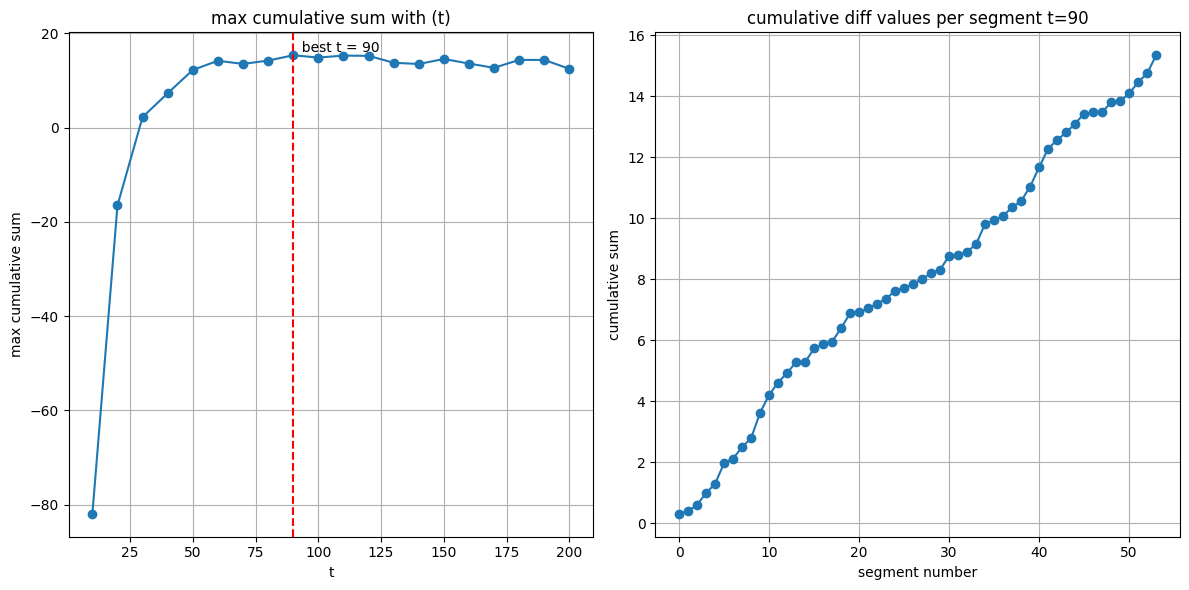

최적의 시간 간격 t = 90
최대 누적 합 = 15.35


In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# # 시계열 데이터가 있다고 가정 (예시 데이터 생성)
# # 실제 사용 시에는 이 부분을 실제 데이터프레임으로 대체하세요
# np.random.seed(42)
# dates = pd.date_range(start='2023-01-01', periods=1000, freq='H')
# df = pd.Series(np.cumsum(np.random.normal(0, 1, 1000)), index=dates)
price = 500

# 테스트할 t 값의 범위 설정
t_values = range(10, 201, 10)  # 10부터 200까지 10 단위로 테스트
max_cumulative_sums = []

# 각 t에 대해 누적 합 계산
for t in t_values:
    num_segments = len(df) // t

    # 세그먼트별 차이값 계산
    segment_diff_values = []
    cumulative_diff_values = []

    # 데이터 분할 및 차이값 계산
    cumulative_sum = 0
    for i in range(num_segments):
        segment = df[i*t:(i+1)*t]
        segment_diff = (segment.max() - segment.min()) - price*0.0011
        segment_diff_values.append(segment_diff)

        # 누적 합 계산
        cumulative_sum += segment_diff
        cumulative_diff_values.append(cumulative_sum)

    # 나머지 데이터 처리
    remainder = df[num_segments*t:]
    if len(remainder) > 0:
        remainder_diff = remainder.max() - remainder.min()
        segment_diff_values.append(remainder_diff)

        # 누적 합에 나머지 세그먼트 차이 추가
        cumulative_sum += remainder_diff
        cumulative_diff_values.append(cumulative_sum)

    # 최종 누적 합 저장
    max_cumulative_sums.append(cumulative_sum)

# 가장 높은 누적 합을 가진 t 찾기
optimal_t = t_values[np.argmax(max_cumulative_sums)]
max_cumulative_sum = max(max_cumulative_sums)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t_values, max_cumulative_sums, 'o-')
plt.axvline(x=optimal_t, color='r', linestyle='--')
plt.text(optimal_t, max_cumulative_sum, f'  best t = {optimal_t}', verticalalignment='bottom')
plt.title('max cumulative sum with (t)')
plt.xlabel('t')
plt.ylabel('max cumulative sum')
plt.grid(True)

# 최적의 t에 대한 세그먼트별 누적 합 시각화
t = optimal_t
num_segments = len(df) // t
segment_diff_values = []
cumulative_diff_values = []

cumulative_sum = 0
for i in range(num_segments):
    segment = df[i*t:(i+1)*t]
    segment_diff = (segment.max() - segment.min()) - price * 0.0011
    segment_diff_values.append(segment_diff)

    cumulative_sum += segment_diff
    cumulative_diff_values.append(cumulative_sum)

remainder = df[num_segments*t:]
if len(remainder) > 0:
    remainder_diff = remainder.max() - remainder.min()
    segment_diff_values.append(remainder_diff)
    cumulative_sum += remainder_diff
    cumulative_diff_values.append(cumulative_sum)

plt.subplot(1, 2, 2)
plt.plot(range(len(cumulative_diff_values)), cumulative_diff_values, 'o-')
plt.title(f'cumulative diff values per segment t={optimal_t}')
plt.xlabel('segment number')
plt.ylabel('cumulative sum')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f'최적의 시간 간격 t = {optimal_t}')
print(f'최대 누적 합 = {max_cumulative_sum:.2f}')

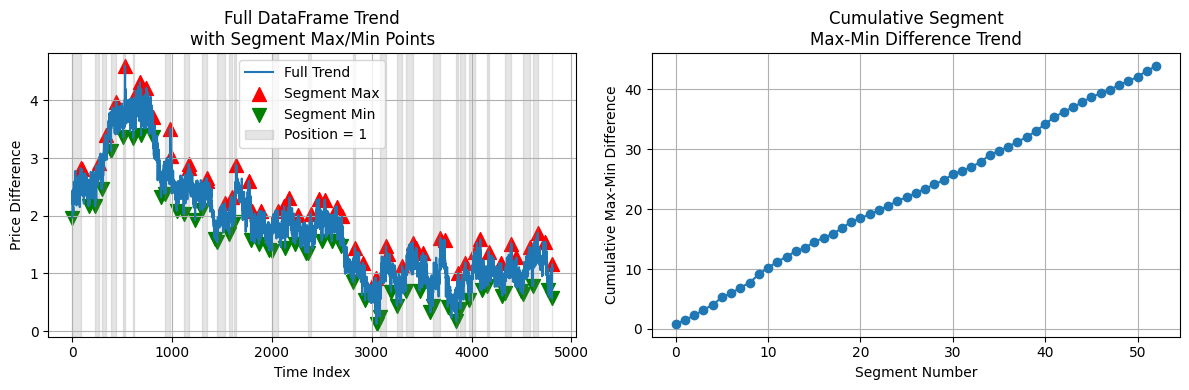

열 값의 의미:
action = 0: 일반 데이터 포인트
action = 2: 세그먼트 내 최대값 발생 시점
action = 1: 세그먼트 내 최소값 발생 시점
position = 0: 일반 구간 또는 최대값에서 최소값으로 가는 구간(하락)
position = 1: 최소값에서 최대값으로 가는 구간(상승)

position = 1인 행의 수: 1261


,price_diff,action,position
0,1.965955,1,1
1,2.051424,0,1
2,2.057673,0,1
3,2.437069,0,1
4,2.273953,0,1
...,...,...,...
4806,0.827074,0,1
4807,0.707800,0,1
4808,1.160647,2,1
4809,1.058077,0,0


In [172]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 서브플롯 생성 (1행 2열)
plt.figure(figsize=(12, 4))

# 첫 번째 서브플롯 (세그먼트 최대/최소 포인트)
plt.subplot(1, 2, 1)
plt.plot(df.index, df.values, label='Full Trend')
plt.title('Full DataFrame Trend\nwith Segment Max/Min Points')
plt.xlabel('Time Index')
plt.ylabel('Price Difference')

# action 열과 position 열 초기화 (0으로)
action_df = pd.DataFrame(df)
action_df["action"] = 0
action_df["position"] = 0

# 각 세그먼트에 대한 최대/최소 누적 차이 저장
cumulative_diff_values = []

for i in range(num_segments):
    segment = df[i*t:(i+1)*t]

    # 빈 세그먼트 확인
    if len(segment) == 0:
        print(f"경고: 세그먼트 {i}가 비어 있습니다. 건너뜁니다.")
        continue

    # 세그먼트 내 최대/최소값과 해당 인덱스 찾기
    segment_max_idx = segment.idxmax()
    segment_max_value = segment.max()
    segment_min_idx = segment.idxmin()
    segment_min_value = segment.min()

    # 중요: action 값 설정
    # 최대값이 발생한 시점에 action = 2 설정
    action_df.loc[segment_max_idx, "action"] = 2

    # 최소값이 발생한 시점에 action = 1 설정
    action_df.loc[segment_min_idx, "action"] = 1

    # 수정된 부분: position 값 설정
    # 최소값이 최대값보다 먼저 나타나는 경우 (상승 추세)
    if segment_min_idx < segment_max_idx:
        action_df.loc[segment_min_idx:segment_max_idx, "position"] = 1
    # 최대값이 최소값보다 먼저 나타나는 경우 (하락 추세)
    else:
        # 이 경우 position은 0을 유지 (최대->최소 구간에서는 position=0)
        pass

    # 누적 차이 계산 및 저장
    diff = abs(segment_max_value - segment_min_value)
    if i == 0:
        cumulative_diff_values.append(diff)
    else:
        cumulative_diff_values.append(cumulative_diff_values[-1] + diff)

    # 시각화용 (선택)
    plt.scatter(segment_max_idx, segment_max_value, color='red', marker='^', s=100, label='Segment Max' if i==0 else "")
    plt.scatter(segment_min_idx, segment_min_value, color='green', marker='v', s=100, label='Segment Min' if i==0 else "")

    # position = 1인 구간만 시각화 (수정됨)
    if segment_min_idx < segment_max_idx:
        plt.axvspan(segment_min_idx, segment_max_idx, alpha=0.2, color='gray', label='Position = 1' if i==0 else "")

# 나머지 데이터 처리 (선택적)
remainder = df[num_segments*t:]
if len(remainder) > 0:  # 나머지 세그먼트가 비어있지 않은 경우에만 처리
    remainder_max_idx = remainder.idxmax()
    remainder_max_value = remainder.max()
    remainder_min_idx = remainder.idxmin()
    remainder_min_value = remainder.min()

    # 나머지 구간의 최대값과 최소값에도 action 설정
    action_df.loc[remainder_max_idx, "action"] = 2
    action_df.loc[remainder_min_idx, "action"] = 1

    # 나머지 구간의 position 설정 (수정됨)
    if remainder_min_idx < remainder_max_idx:
        action_df.loc[remainder_min_idx:remainder_max_idx, "position"] = 1

    plt.scatter(remainder_max_idx, remainder_max_value, color='red', marker='^', s=100)
    plt.scatter(remainder_min_idx, remainder_min_value, color='green', marker='v', s=100)

    # 시각화도 조건부로 변경
    if remainder_min_idx < remainder_max_idx:
        plt.axvspan(remainder_min_idx, remainder_max_idx, alpha=0.2, color='gray')

plt.grid(True)
plt.legend()

# cumulative_diff_values가 비어있는지 확인
if len(cumulative_diff_values) > 0:
    # 두 번째 서브플롯 (누적 차이 트렌드)
    plt.subplot(1, 2, 2)
    plt.plot(range(len(cumulative_diff_values)), cumulative_diff_values, marker='o')
    plt.title('Cumulative Segment\nMax-Min Difference Trend')
    plt.xlabel('Segment Number')
    plt.ylabel('Cumulative Max-Min Difference')
    plt.grid(True)
else:
    print("경고: cumulative_diff_values가 비어 있어 두 번째 서브플롯을 그리지 않습니다.")

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

# 각 열의 의미 출력
print("열 값의 의미:")
print("action = 0: 일반 데이터 포인트")
print("action = 2: 세그먼트 내 최대값 발생 시점")
print("action = 1: 세그먼트 내 최소값 발생 시점")
print("position = 0: 일반 구간 또는 최대값에서 최소값으로 가는 구간(하락)")
print("position = 1: 최소값에서 최대값으로 가는 구간(상승)")

# position이 1인 행의 수
position_ones = action_df[action_df["position"] == 1]
print(f"\nposition = 1인 행의 수: {len(position_ones)}")

action_df

In [173]:
dataset = action_df.copy()

In [174]:
# EMA 계산
def EMA(df, n):
    EMA = pd.Series(df['price_diff'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA1'] = EMA(dataset, 1)
dataset['EMA3'] = EMA(dataset, 3)
dataset['EMA10'] = EMA(dataset, 10)
dataset.head()

# 모멘텀 (MOM) 계산
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM1'] = MOM(dataset['price_diff'], 1)
dataset['MOM3'] = MOM(dataset['price_diff'], 3)
dataset['MOM3'] = MOM(dataset['price_diff'], 10)

#상대강도지수 (RSI) 계산
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)

dataset['RSI1'] = RSI(dataset['price_diff'], 1)
dataset['RSI3'] = RSI(dataset['price_diff'], 3)
dataset['RSI10'] = RSI(dataset['price_diff'], 10)

# 이동평균 (MA) 계산
def MA(df, n):
    MA = pd.Series(df['price_diff'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA1'] = MA(dataset, 1)
dataset['MA3'] = MA(dataset, 3)
dataset['MA10'] = MA(dataset, 10)

def Price_EMA_Diff(df, n):
    ema = df['price_diff'].ewm(span=n, min_periods=n).mean()
    diff = df['price_diff'] - ema
    return pd.Series(diff, name=f'Price_EMA_Diff_{n}')

dataset['PEMA1'] = Price_EMA_Diff(dataset, 1)
dataset['PEMA3'] = Price_EMA_Diff(dataset, 3)
dataset['PEMA10'] = Price_EMA_Diff(dataset, 10)

def CCI(df, n):
    ma = df['price_diff'].rolling(window=n).mean()
    md = df['price_diff'].rolling(window=n).apply(lambda x: np.mean(np.abs(x - np.mean(x))))
    cci = (df['price_diff'] - ma) / (0.015 * md)
    return pd.Series(cci, name=f'CCI_{n}')

dataset['CCI3'] = CCI(dataset, 3)
dataset['CCI10'] = CCI(dataset, 10)

def WilliamsR(series, n):
    high = series.rolling(window=n).max()
    low = series.rolling(window=n).min()
    r = -100 * (high - series) / (high - low)
    return pd.Series(r, name=f'WilliamsR_{n}')

dataset['WILLR3'] = WilliamsR(dataset['price_diff'], 3)
dataset['WILLR10'] = WilliamsR(dataset['price_diff'], 10)

def STDDEV(df, n):
    std = df['price_diff'].rolling(window=n).std()
    return pd.Series(std, name=f'STD_{n}')

dataset['STD3'] = STDDEV(dataset, 3)
dataset['STD10'] = STDDEV(dataset, 10)

def MACD(series, fast=12, slow=26, signal=9, prefix=''):

    ema_fast = series.ewm(span=fast, min_periods=fast).mean()
    ema_slow = series.ewm(span=slow, min_periods=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, min_periods=signal).mean()
    histogram = macd_line - signal_line

    if prefix:
        prefix = f"{prefix}_"

    return pd.DataFrame({
        f'{prefix}MACD_{fast}_{slow}_{signal}': macd_line,
        f'{prefix}MACD_Signal_{fast}_{slow}_{signal}': signal_line,
        f'{prefix}MACD_Hist_{fast}_{slow}_{signal}': histogram
    })

macd_df = MACD(dataset['price_diff'])
dataset = pd.concat([dataset, macd_df], axis=1)

macd_params = [
    {'fast': 5, 'slow': 15, 'signal': 5, 'prefix': 'Short'},
    {'fast': 10, 'slow': 20, 'signal': 7, 'prefix': 'Med'},
    {'fast': 15, 'slow': 30, 'signal': 10, 'prefix': 'Long'},
    {'fast': 3, 'slow': 10, 'signal': 3, 'prefix': 'UltraShort'},
    {'fast': 20, 'slow': 40, 'signal': 15, 'prefix': 'UltraLong'}
]

for params in macd_params:
    macd_variant = MACD(dataset['price_diff'], **params)
    dataset = pd.concat([dataset, macd_variant], axis=1)

print(f"추가된 MACD 지표: {len(macd_params) + 1}개")
print("MACD 관련 컬럼:")

macd_columns = [col for col in dataset.columns if 'MACD' in col]

for col in macd_columns:
    print(f"  - {col}")

def Bollinger_Bands(series, n=20, k=2):
    ma = series.rolling(window=n).mean()
    std = series.rolling(window=n).std()
    upper = ma + (k * std)
    lower = ma - (k * std)
    return pd.DataFrame({
        f'BB_MA_{n}': ma,
        f'BB_Upper_{n}': upper,
        f'BB_Lower_{n}': lower
    })

bb_df = Bollinger_Bands(dataset['price_diff'], n=20, k=2)
dataset = pd.concat([dataset, bb_df], axis=1)

def StochRSI(series, period=14):
    rsi = RSI(series, period).dropna()
    stoch_rsi = (rsi - rsi.rolling(window=period).min()) / \
                (rsi.rolling(window=period).max() - rsi.rolling(window=period).min())
    return pd.Series(stoch_rsi, name=f'StochRSI_{period}')

dataset['StochRSI14'] = StochRSI(dataset['price_diff'], 14)


추가된 MACD 지표: 6개
MACD 관련 컬럼:
  - MACD_12_26_9
  - MACD_Signal_12_26_9
  - MACD_Hist_12_26_9
  - Short_MACD_5_15_5
  - Short_MACD_Signal_5_15_5
  - Short_MACD_Hist_5_15_5
  - Med_MACD_10_20_7
  - Med_MACD_Signal_10_20_7
  - Med_MACD_Hist_10_20_7
  - Long_MACD_15_30_10
  - Long_MACD_Signal_15_30_10
  - Long_MACD_Hist_15_30_10
  - UltraShort_MACD_3_10_3
  - UltraShort_MACD_Signal_3_10_3
  - UltraShort_MACD_Hist_3_10_3
  - UltraLong_MACD_20_40_15
  - UltraLong_MACD_Signal_20_40_15
  - UltraLong_MACD_Hist_20_40_15


In [175]:
dataset.tail()

,price_diff,action,position,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,...,UltraShort_MACD_3_10_3,UltraShort_MACD_Signal_3_10_3,UltraShort_MACD_Hist_3_10_3,UltraLong_MACD_20_40_15,UltraLong_MACD_Signal_20_40_15,UltraLong_MACD_Hist_20_40_15,BB_MA_20,BB_Upper_20,BB_Lower_20,StochRSI14
4806,0.827074,0,1,0.827074,0.727395,0.747389,0.260827,0.120850,100.0,68.959516,...,-0.019994,-0.045883,0.025889,-0.052331,-0.054059,0.001728,0.812821,1.105971,0.519670,0.609328
4807,0.707800,0,1,0.707800,0.717597,0.740191,-0.119274,-0.024012,0.0,47.874379,...,-0.022593,-0.034238,0.011645,-0.052996,-0.053926,0.000930,0.814745,1.104413,0.525077,0.372326
4808,1.160647,2,1,1.160647,0.939122,0.816637,0.452847,0.457989,100.0,80.985224,...,0.122485,0.044123,0.078362,-0.032284,-0.051221,0.018936,0.827278,1.153660,0.500895,1.000000
4809,1.058077,0,0,1.058077,0.998600,0.860536,-0.102570,0.382548,0.0,66.609869,...,0.138064,0.091094,0.046970,-0.019074,-0.047203,0.028128,0.833503,1.172912,0.494094,0.824981
4810,1.081835,0,0,1.081835,1.040217,0.900772,0.023758,0.295307,100.0,68.549470,...,0.139445,0.115270,0.024176,-0.006513,-0.042116,0.035603,0.839079,1.191370,0.486787,0.855735


In [176]:
# 무한대 값 검사
is_inf = dataset.isin([np.inf, -np.inf])

# 열별 무한대 값 개수
inf_count_per_column = is_inf.sum()
print("열별 무한대 값 개수:")
print(inf_count_per_column)
print("\n무한대 값이 있는 열:")
print(inf_count_per_column[inf_count_per_column > 0].index.tolist())

# 행별 무한대 값 개수
inf_count_per_row = is_inf.sum(axis=1)
print("\n행별 무한대 값 개수:")
print(inf_count_per_row)
print("\n무한대 값이 있는 행 인덱스:")
print(inf_count_per_row[inf_count_per_row > 0].index.tolist())

# 무한대 값이 포함된 행 데이터
rows_with_inf = dataset[is_inf.any(axis=1)]
print("\n무한대가 포함된 행 데이터:")
print(rows_with_inf)

# 무한대 값의 정확한 위치 찾기 (행, 열 인덱스)
inf_positions = []
for row_idx, row in enumerate(is_inf.values):
    for col_idx, value in enumerate(row):
        if value:
            inf_positions.append({
                '행 인덱스': row_idx,
                '행 레이블': dataset.index[row_idx],
                '열 이름': dataset.columns[col_idx],
                '값': dataset.iloc[row_idx, col_idx]
            })

# 무한대 값의 정확한 위치 출력
print("\n무한대 값의 정확한 위치:")
for pos in inf_positions:
    print(f"행 인덱스: {pos['행 인덱스']}, 행 레이블: {pos['행 레이블']}, 열 이름: {pos['열 이름']}, 값: {pos['값']}")

# 또는 데이터프레임으로 출력
inf_positions_df = pd.DataFrame(inf_positions)
print("\n무한대 값의 위치 (데이터프레임 형식):")
print(inf_positions_df)

열별 무한대 값 개수:
price_diff                        0
action                            0
position                          0
EMA1                              0
EMA3                              0
EMA10                             0
MOM1                              0
MOM3                              0
RSI1                              0
RSI3                              0
RSI10                             0
MA1                               0
MA3                               0
MA10                              0
PEMA1                             0
PEMA3                             0
PEMA10                            0
CCI3                              0
CCI10                             0
WILLR3                            0
WILLR10                           0
STD3                              0
STD10                             0
MACD_12_26_9                      0
MACD_Signal_12_26_9               0
MACD_Hist_12_26_9                 0
Short_MACD_5_15_5                 0
Short_MACD_Sign

In [177]:
dataset = dataset.dropna(axis=0)
dataset

,price_diff,action,position,EMA1,EMA3,EMA10,MOM1,MOM3,RSI1,RSI3,...,UltraShort_MACD_3_10_3,UltraShort_MACD_Signal_3_10_3,UltraShort_MACD_Hist_3_10_3,UltraLong_MACD_20_40_15,UltraLong_MACD_Signal_20_40_15,UltraLong_MACD_Hist_20_40_15,BB_MA_20,BB_Upper_20,BB_Lower_20,StochRSI14
53,2.294295,0,1,2.294295,2.357139,2.393599,-0.027131,-0.056310,0.0,27.975715,...,-0.036460,-0.003767,-0.032693,-0.002031,0.003528,-0.005559,2.403164,2.618698,2.187630,0.301479
54,2.443391,0,1,2.443391,2.400265,2.402652,0.149096,0.263628,100.0,58.910654,...,-0.002387,-0.003077,0.000690,-0.000267,0.002990,-0.003257,2.406818,2.622485,2.191150,0.682831
55,2.425928,0,1,2.425928,2.413096,2.406884,-0.017463,-0.038806,0.0,54.777159,...,0.006212,0.001568,0.004645,0.000489,0.002642,-0.002153,2.405454,2.620229,2.190678,0.636849
56,2.428716,0,1,2.428716,2.420906,2.410854,0.002788,0.072992,100.0,55.524400,...,0.010052,0.005810,0.004242,0.001259,0.002452,-0.001193,2.404717,2.619043,2.190390,0.644343
57,2.206140,0,1,2.206140,2.313523,2.373633,-0.222576,-0.034954,0.0,18.639148,...,-0.060110,-0.027150,-0.032960,-0.007857,0.001052,-0.008910,2.389316,2.614523,2.164110,0.070171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4806,0.827074,0,1,0.827074,0.727395,0.747389,0.260827,0.120850,100.0,68.959516,...,-0.019994,-0.045883,0.025889,-0.052331,-0.054059,0.001728,0.812821,1.105971,0.519670,0.609328
4807,0.707800,0,1,0.707800,0.717597,0.740191,-0.119274,-0.024012,0.0,47.874379,...,-0.022593,-0.034238,0.011645,-0.052996,-0.053926,0.000930,0.814745,1.104413,0.525077,0.372326
4808,1.160647,2,1,1.160647,0.939122,0.816637,0.452847,0.457989,100.0,80.985224,...,0.122485,0.044123,0.078362,-0.032284,-0.051221,0.018936,0.827278,1.153660,0.500895,1.000000
4809,1.058077,0,0,1.058077,0.998600,0.860536,-0.102570,0.382548,0.0,66.609869,...,0.138064,0.091094,0.046970,-0.019074,-0.047203,0.028128,0.833503,1.172912,0.494094,0.824981


<a id='3.4'></a>
## 3.3. 데이터 시각화

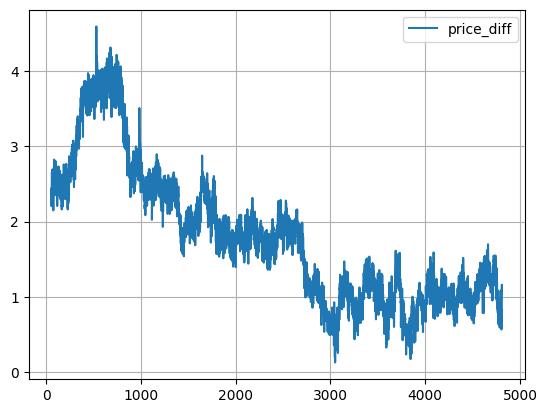

In [178]:
# 트렌드
dataset[['price_diff']].plot(grid=True)
plt.show()

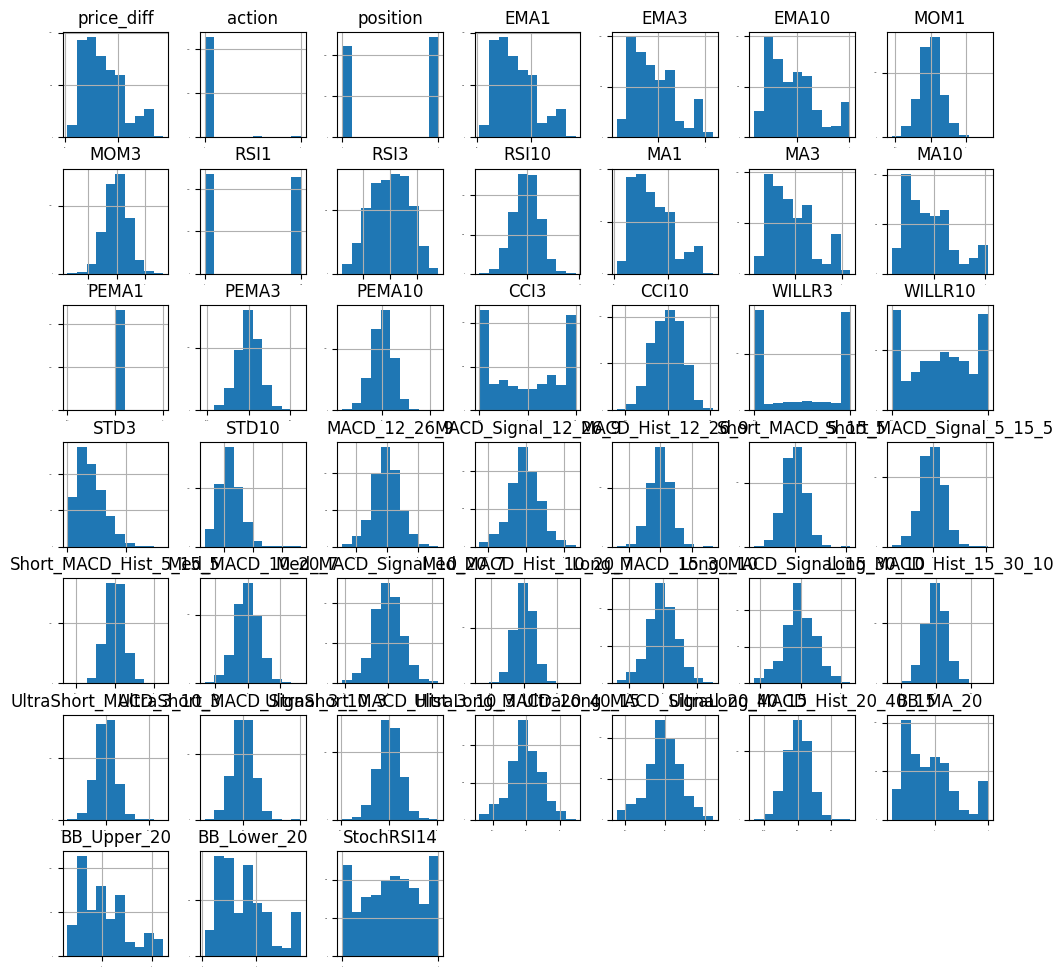

In [145]:
# 히스토그램
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

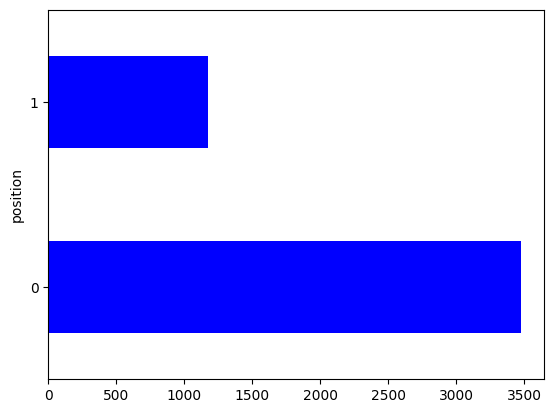

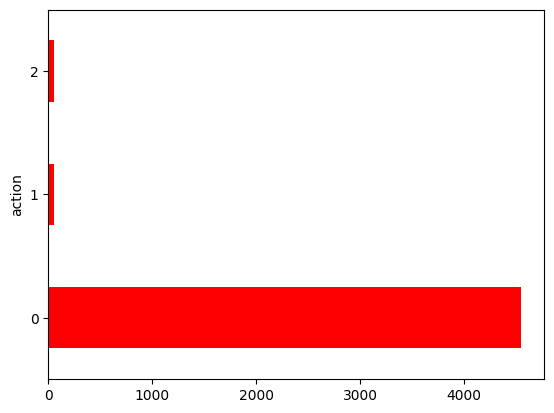

In [196]:
# 행동들 간 비율
fig = plt.figure()
plot = dataset.groupby(['position']).size().plot(kind='barh', color='blue')
plt.show()

# 행동들 간 비율
fig = plt.figure()
plot = dataset.groupby(['action']).size().plot(kind='barh', color='red')
plt.show()

KeyboardInterrupt: 

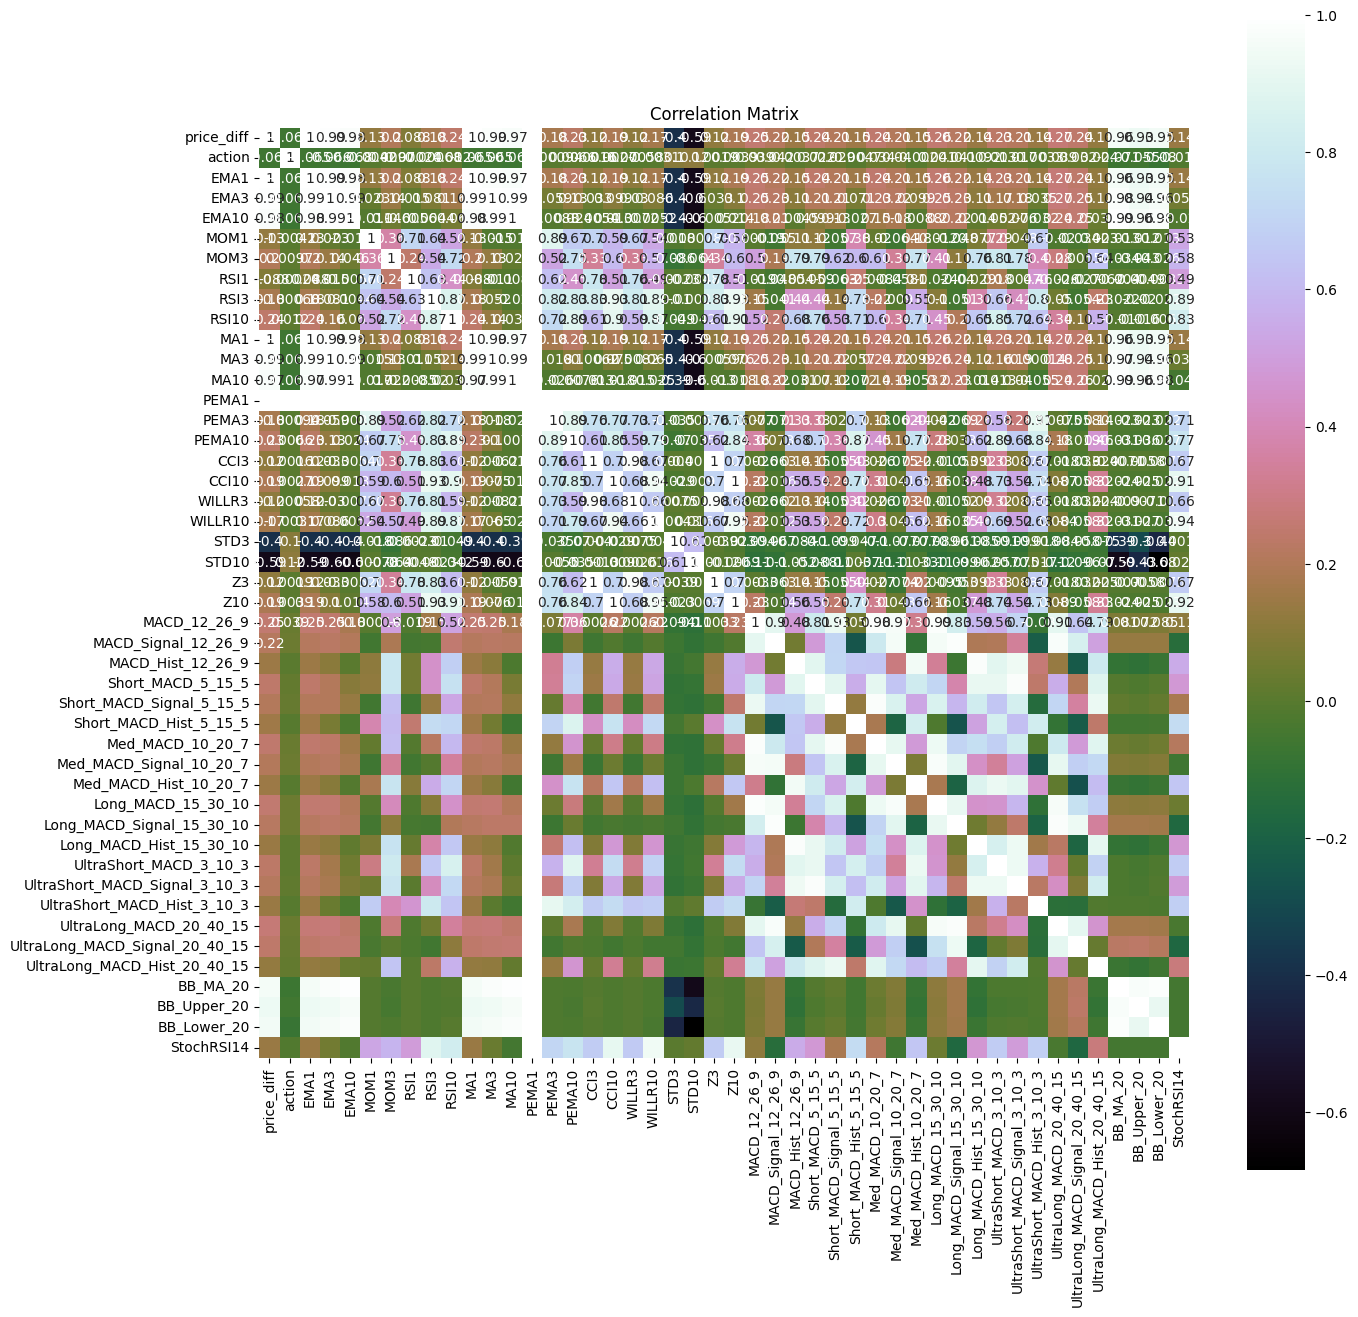

In [ ]:
# 상관계수
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='4'></a>
# 4. 알고리즘 및 모델 평가

<a id='4.1'></a>
## 4.1. train test 분리

80퍼는 학습셋으로, 20퍼는 평가셋으로

In [226]:
subset_dataset= dataset
Y = subset_dataset["action"]
X = subset_dataset.loc[:, dataset.columns != 'action']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

<a id='4.2'></a>
## 4.2. 테스트 옵션 및 평가 지표


In [199]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='4.3'></a>
## 4.3. 모델 및 알고리즘 비교

<a id='4.3.1'></a>
### 4.3.1. 모델 정의

In [182]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

### 4.3.2. K-겹 교차 검증

In [161]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.524194 (0.028952)
LDA: 0.578495 (0.016693)
KNN: 0.494624 (0.021938)
CART: 0.777419 (0.020641)
NB: 0.522312 (0.029053)
NN: 0.530914 (0.015869)
AB: 0.513441 (0.028878)
GBM: 0.753495 (0.018704)
RF: 0.808065 (0.022879)


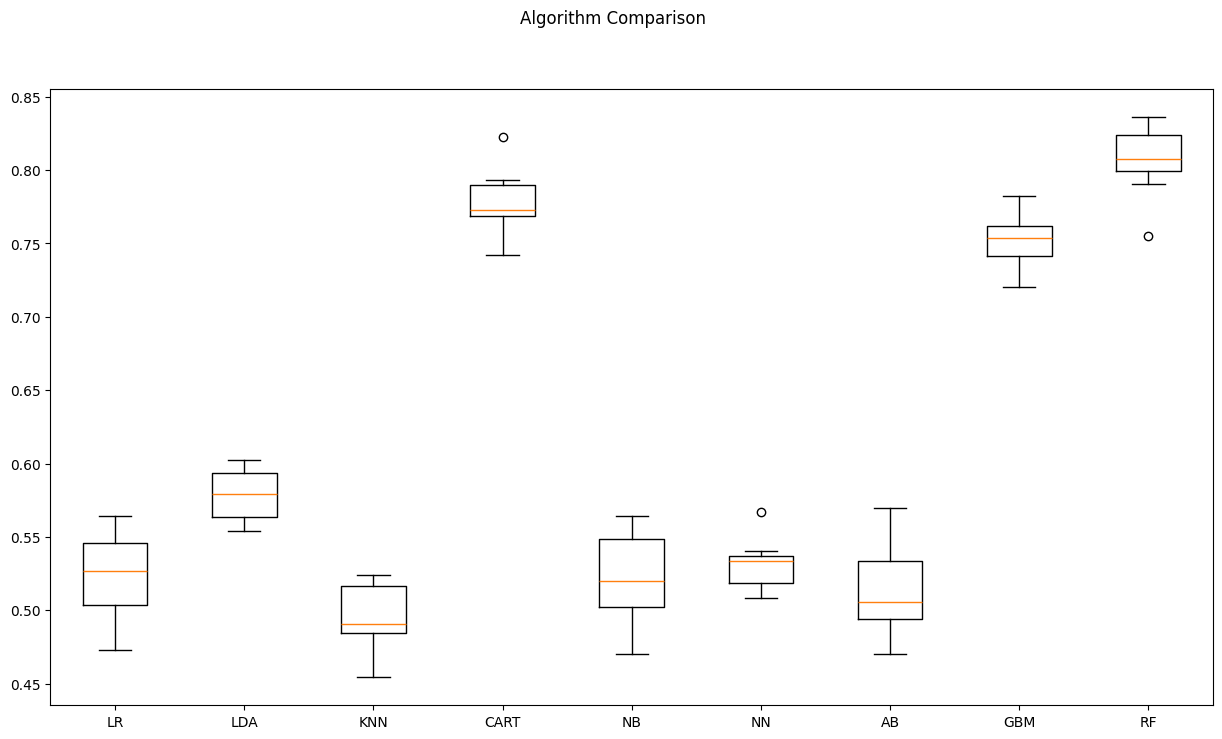

In [162]:
# 알고리즘 비교
# results.append([accuracy_keras] * len(results[0]))  # accuracy_keras 값을 모든 항목에 추가 (같은 값 반복)
# names.append('Keras')
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

<a id='5'></a>
# 5. 그리드 서치 & 베이지안 최적화를 통한 모델 튜닝

In [87]:
# 랜덤 포레스트 그리드 서치
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

# 결과 출력
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

KeyboardInterrupt: 

In [65]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.9 MB/s eta 0:00:00


In [66]:
# 랜덤 포레스트 베이지안 최적화
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

param_space = {
    'n_estimators': Integer(300, 400),
    'max_depth': Integer(40, 50),
    'criterion': Categorical(['gini', 'entropy'])
}

model = RandomForestClassifier(n_jobs=-1, random_state=seed)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=12,
    scoring=scoring,
    cv=kfold,
    n_jobs=-1,
    verbose=1,
    random_state=seed,
    return_train_score=True
)

bayes_result = bayes_search.fit(rescaledX, Y_train)

# 결과 출력
print("Best: %f using %s" % (bayes_result.best_score_, bayes_result.best_params_))
means = bayes_result.cv_results_['mean_test_score']
stds = bayes_result.cv_results_['std_test_score']
params = bayes_result.cv_results_['params']
ranks = bayes_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


KeyboardInterrupt: 

<a id='6'></a>
# 6. 최적 모델 정의

<a id='6.1'></a>
## 6.1. 테스트셋에서의 성능 평가

In [227]:
model = RandomForestClassifier(criterion='entropy', n_estimators=400, max_depth=20,n_jobs=-1)
model.fit(X_train, Y_train)
# model = LogisticRegression()
# model = create_nn()
# model.fit(X_train, Y_train, epochs=500, batch_size=32, verbose=1)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=400,
                       n_jobs=-1)

In [228]:
predictions = model.predict(X_validation)
# predictions = (model.predict(X_validation) > 0.5).astype(int)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9688172043010753
[[900   1   2]
 [ 11   1   0]
 [ 15   0   0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       903
           1       0.50      0.08      0.14        12
           2       0.00      0.00      0.00        15

    accuracy                           0.97       930
   macro avg       0.49      0.36      0.38       930
weighted avg       0.95      0.97      0.96       930



<Axes: xlabel='Predicted', ylabel='Actual'>

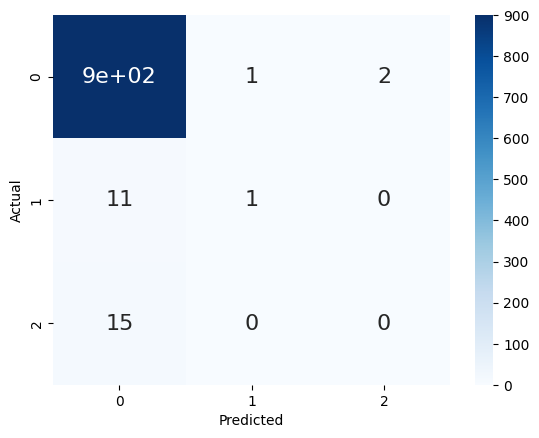

In [229]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

<a id='6.2'></a>
## 6.2. 변수 및 특성 중요도
모델에서 가장 중요한 특성 및 변수를 알아보자

Text(0.5, 0, 'Variable Importance')

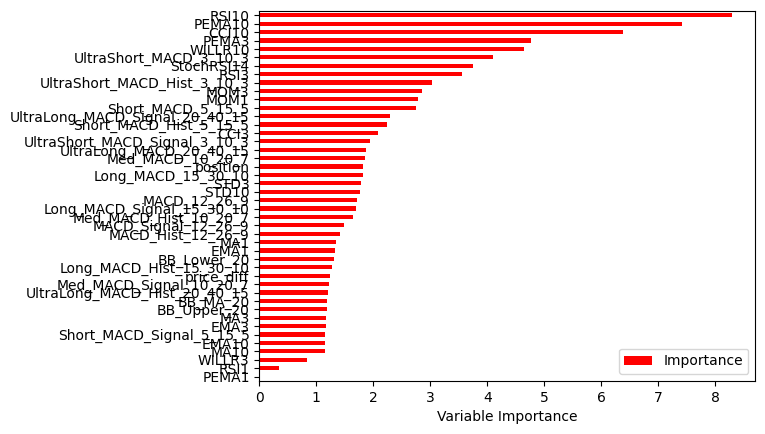

In [230]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<a id='7'></a>
## 7. 결과 백테스트

<Axes: >

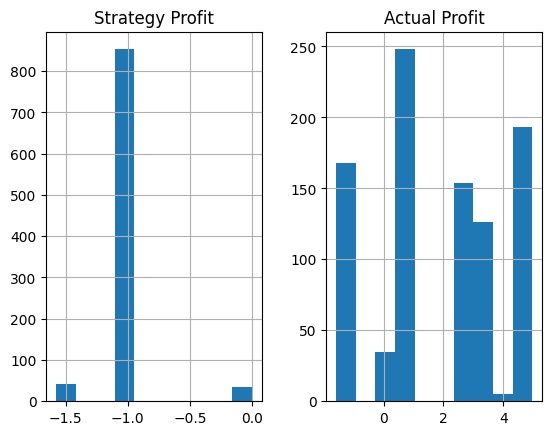

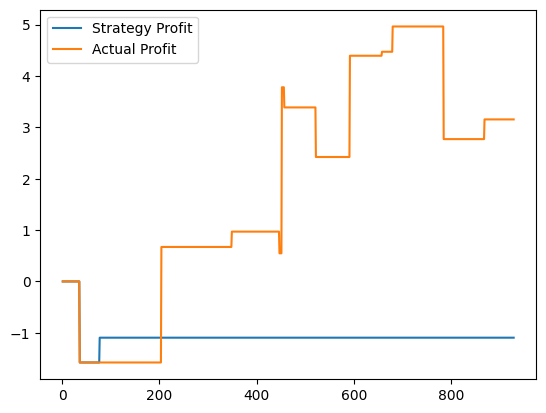

In [231]:
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['action_pred'] = predictions
backtestdata['action_actual'] = Y_validation
# backtestdata['Market Returns'] = X_validation['Price'].pct_change()
# backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['action_actual'].shift(1)
# backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['action_pred'].shift(1)
backtestdata['Market Profit'] = X_validation['price_diff'].diff()
backtestdata['Strategy Profit'] = backtestdata['Market Profit'] * (backtestdata['action_pred'].shift(1) == 1)
backtestdata['Actual Profit'] = backtestdata['Market Profit'] * (backtestdata['action_actual'].shift(1) == 1)

backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().hist()
backtestdata[['Strategy Profit','Actual Profit']].cumsum().plot()

백테스트 결과 (처음 5행):
   index  action_pred  action_actual  position_pred  position_actual  Market Profit  \
1   1837            0              0              0                0       0.629142   
2   3810            0              0              0                0      -1.375282   
3   2187            0              0              0                0       1.390139   
4    115            0              0              0                0       0.880888   
5   4719            0              0              0                0      -1.291386   

   Strategy Profit  Actual Profit  
1              0.0            0.0  
2             -0.0           -0.0  
3              0.0            0.0  
4              0.0            0.0  
5             -0.0           -0.0  


<Figure size 1400x600 with 0 Axes>

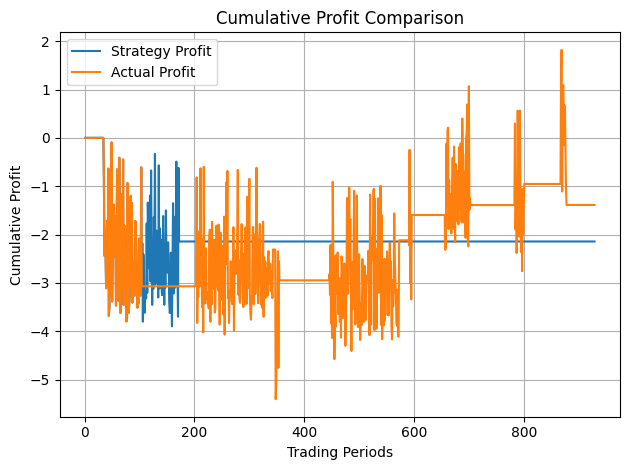

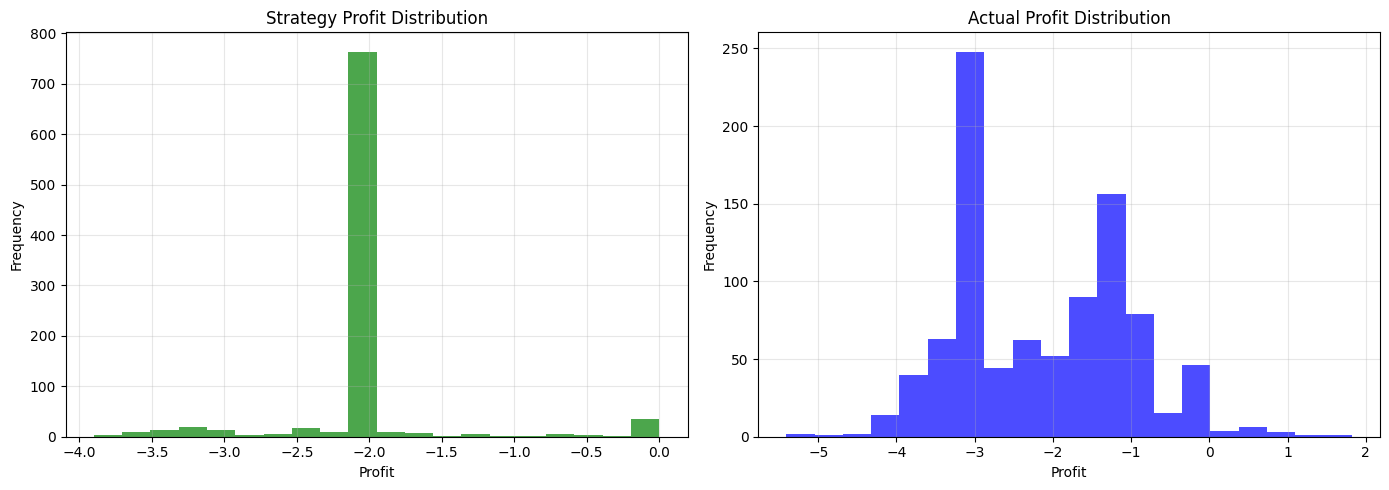


Final Strategy Profit: -2.14
Final Actual Profit: -1.39

Strategy Position Ratio: 14.85%
Actual Position Ratio: 46.18%

Strategy Win Rate: 7.10%
Actual Win Rate: 23.47%


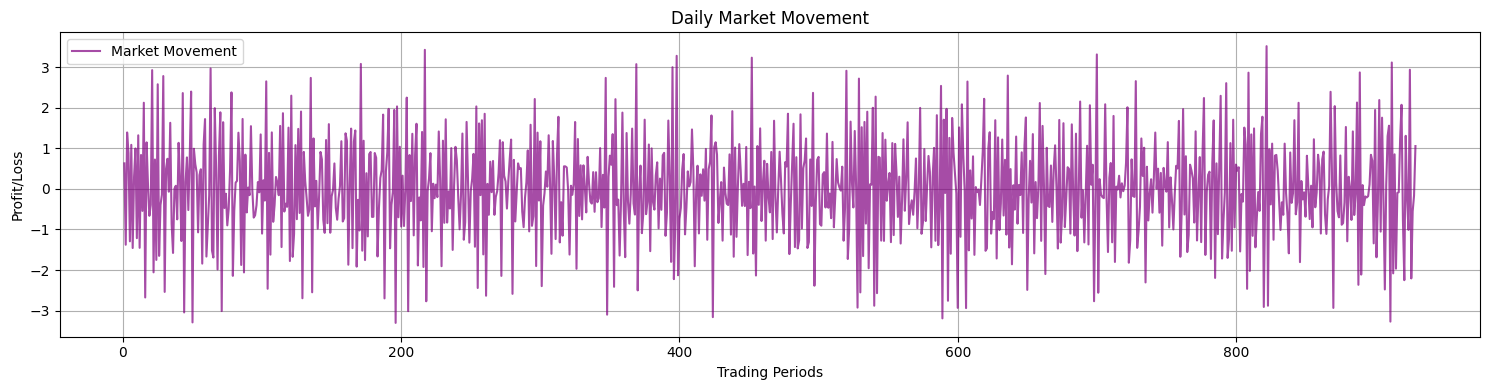

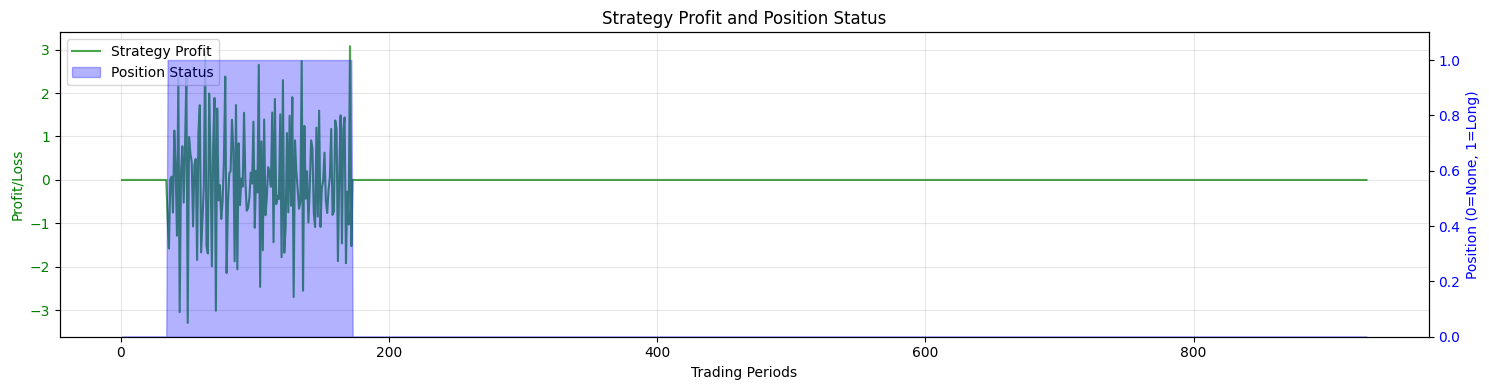

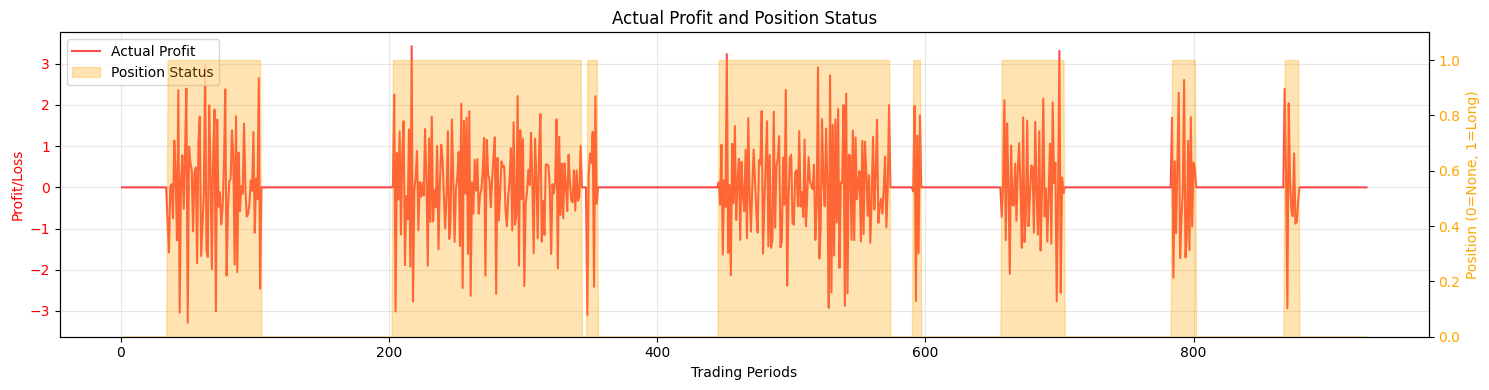

<Figure size 640x480 with 0 Axes>

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

# 백테스트 데이터프레임 초기화
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['action_pred'] = predictions
backtestdata['action_actual'] = Y_validation

# 포지션 컬럼 생성 (실제와 예측 모두)
backtestdata['position_pred'] = 0
backtestdata['position_actual'] = 0

# 예측 포지션 계산: 1이 나오면 매수 시작, 2가 나오면 포지션 종료
in_position_pred = False
for i in range(len(backtestdata)):
    if backtestdata['action_pred'].iloc[i] == 1:
        in_position_pred = True
    elif backtestdata['action_pred'].iloc[i] == 2:
        in_position_pred = False

    backtestdata['position_pred'].iloc[i] = 1 if in_position_pred else 0

# 실제 포지션 계산: 1이 나오면 매수 시작, 2가 나오면 포지션 종료
in_position_actual = False
for i in range(len(backtestdata)):
    if backtestdata['action_actual'].iloc[i] == 1:
        in_position_actual = True
    elif backtestdata['action_actual'].iloc[i] == 2:
        in_position_actual = False

    backtestdata['position_actual'].iloc[i] = 1 if in_position_actual else 0

# 수익 계산 (포지션 기반)
backtestdata['Market Profit'] = X_validation['price_diff'].diff()
# 포지션이 1일 때만 수익을 계산 (당일 포지션으로 당일 수익 계산)
backtestdata['Strategy Profit'] = backtestdata['Market Profit'] * backtestdata['position_pred']
backtestdata['Actual Profit'] = backtestdata['Market Profit'] * backtestdata['position_actual']

# 인덱스 리셋 및 결과 확인
backtestdata = backtestdata.reset_index()

# NaN 값 제거 (첫 번째 행의 diff 결과는 NaN)
backtestdata = backtestdata.dropna()

# 결과 확인
print("백테스트 결과 (처음 5행):")
print(backtestdata.head())

# 수익 그래프 생성 - 별도의 Figure로 분리
# 1. 누적 수익 그래프
plt.figure(figsize=(14, 6))
backtestdata[['Strategy Profit', 'Actual Profit']].cumsum().plot()
plt.title('Cumulative Profit Comparison')
plt.xlabel('Trading Periods')
plt.ylabel('Cumulative Profit')
plt.legend(['Strategy Profit', 'Actual Profit'])
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 히스토그램 (별도 figure에 나란히 배치)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 첫 번째 히스토그램
axes[0].hist(backtestdata['Strategy Profit'].cumsum(), bins=20, alpha=0.7, color='green')
axes[0].set_title('Strategy Profit Distribution')
axes[0].set_xlabel('Profit')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# 두 번째 히스토그램
axes[1].hist(backtestdata['Actual Profit'].cumsum(), bins=20, alpha=0.7, color='blue')
axes[1].set_title('Actual Profit Distribution')
axes[1].set_xlabel('Profit')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 성과 통계
strategy_profit = backtestdata['Strategy Profit'].cumsum().iloc[-1]
actual_profit = backtestdata['Actual Profit'].cumsum().iloc[-1]

print(f"\nFinal Strategy Profit: {strategy_profit:.2f}")
print(f"Final Actual Profit: {actual_profit:.2f}")

# 포지션 유지 비율
strategy_ratio = backtestdata['position_pred'].mean() * 100
actual_ratio = backtestdata['position_actual'].mean() * 100

print(f"\nStrategy Position Ratio: {strategy_ratio:.2f}%")
print(f"Actual Position Ratio: {actual_ratio:.2f}%")

# 승률 계산 (수익이 0보다 큰 거래의 비율)
strategy_win_rate = (backtestdata['Strategy Profit'] > 0).mean() * 100
actual_win_rate = (backtestdata['Actual Profit'] > 0).mean() * 100

print(f"\nStrategy Win Rate: {strategy_win_rate:.2f}%")
print(f"Actual Win Rate: {actual_win_rate:.2f}%")

# 일별 수익과 포지션 상태 시각화 - 완전히 재작성된 버전
# 3개의 개별 그래프를 별도로 생성

# 첫 번째 그래프: 시장 변동
fig1 = plt.figure(figsize=(15, 4))
ax1 = fig1.add_subplot(111)
ax1.plot(backtestdata.index, backtestdata['Market Profit'], label='Market Movement', color='purple', alpha=0.7)
ax1.set_title('Daily Market Movement')
ax1.set_xlabel('Trading Periods')
ax1.set_ylabel('Profit/Loss')
ax1.grid(True)
ax1.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 두 번째 그래프: 전략 수익 및 포지션
fig2 = plt.figure(figsize=(15, 4))
ax2_1 = fig2.add_subplot(111)
ax2_2 = ax2_1.twinx()  # 두 번째 y축 생성

# 수익 그래프
ax2_1.plot(backtestdata.index, backtestdata['Strategy Profit'], label='Strategy Profit', color='green', alpha=0.7)
ax2_1.set_xlabel('Trading Periods')
ax2_1.set_ylabel('Profit/Loss', color='green')
ax2_1.tick_params(axis='y', labelcolor='green')
ax2_1.grid(True, alpha=0.3)

# 포지션 그래프
ax2_2.fill_between(backtestdata.index, 0, backtestdata['position_pred'],
                 label='Position Status', color='blue', alpha=0.3)
ax2_2.set_ylabel('Position (0=None, 1=Long)', color='blue')
ax2_2.set_ylim(0, 1.1)
ax2_2.tick_params(axis='y', labelcolor='blue')

plt.title('Strategy Profit and Position Status')
# 양쪽 축에 대한 레전드 합치기
lines1, labels1 = ax2_1.get_legend_handles_labels()
lines2, labels2 = ax2_2.get_legend_handles_labels()
ax2_1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.tight_layout()
plt.show()

# 세 번째 그래프: 실제 수익 및 포지션
fig3 = plt.figure(figsize=(15, 4))
ax3_1 = fig3.add_subplot(111)
ax3_2 = ax3_1.twinx()  # 두 번째 y축 생성

# 수익 그래프
ax3_1.plot(backtestdata.index, backtestdata['Actual Profit'], label='Actual Profit', color='red', alpha=0.7)
ax3_1.set_xlabel('Trading Periods')
ax3_1.set_ylabel('Profit/Loss', color='red')
ax3_1.tick_params(axis='y', labelcolor='red')
ax3_1.grid(True, alpha=0.3)

# 포지션 그래프
ax3_2.fill_between(backtestdata.index, 0, backtestdata['position_actual'],
                 label='Position Status', color='orange', alpha=0.3)
ax3_2.set_ylabel('Position (0=None, 1=Long)', color='orange')
ax3_2.set_ylim(0, 1.1)
ax3_2.tick_params(axis='y', labelcolor='orange')

plt.title('Actual Profit and Position Status')
# 양쪽 축에 대한 레전드 합치기
lines1, labels1 = ax3_1.get_legend_handles_labels()
lines2, labels2 = ax3_2.get_legend_handles_labels()
ax3_1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()